# Example of DOV search methods for samples (monsters)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/DOV-Vlaanderen/pydov/master?filepath=docs%2Fnotebooks%2Fsearch_grondmonsters.ipynb)

## Use cases explained below
* Get samples in a bounding box
* Get samples in a bounding box based on specific properties
* Get sample based on fields not available in the standard output dataframe
* Get a boxplot with the depth distribution of samples with sampling instrument 'steekbuis'
* Finding the boreholes associated with the monsters and visualize results
* Adding the sampled object to the monster dataframe

In [4]:
%matplotlib inline
import inspect, sys

In [3]:
# check pydov path
import pydov

## Get information about the datatype 'Monster'

In [5]:
from pydov.search.monster import MonsterSearch
monster = MonsterSearch()

A description is provided for the 'Monster' datatype:

In [4]:
print(monster.get_description())

Monsters in DOV zijn monsters die gekoppeld zijn aan een boring. Deze monsters zijn gekenmerkt door een diepte ten opzichte van het maaiveld en door de manier van staalname. De geografische ligging (X en Y (mL72) en Z (mTAW)) nemen ze over van de gekoppelde boring. Aan deze monsters zijn laboproeven, namelijk resultaten afkomstig van analyses in het laboratorium of enkel referenties naar bepaalde analyses, gekoppeld. De analyseresultaten van de monsters kunnen zeer divers zijn, namelijk onderkenningsproeven met centraal de korrelgrootteverdeling maar ook plasticiteitsgrenzen en humus- en kalkgehalte, metingen van volumemassa- en watergehalte en referenties van doorlatendheid, samendrukbaarheid en schuifweerstandkarakteristieken, glauconietgehalte en steenkoolanalyses. De gegevens van de monsters en de laboresultaten kunnen worden geëxporteerd in een rapport.


The different fields that are available for objects of the 'Grondmonster' datatype can be requested with the get_fields() method:

In [5]:
fields = monster.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

id
naam
pkey_monster
gekoppeld_aan
pkey_parents
materiaalklasse
diepte_van_m
diepte_tot_m
observaties
datum_monstername
monstersamenstelling
monstertype
bemonsteringsprocedure
bemonsteringsinstrument
bemonstering_door
opmerkingen
opslaglocatie
opdracht
permkey_monster
geom


You can get more information of a field by requesting it from the fields dictionary:
* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field

In [6]:
fields['materiaalklasse']

{'name': 'materiaalklasse',
 'definition': 'aan te vullen',
 'type': 'string',
 'list': False,
 'notnull': False,
 'query': True,
 'cost': 1}

## Example use cases

### Get samples in a bounding box

Get data for all the samples that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [7]:
from pydov.util.location import Within, Box

df = monster.search(location=Within(Box(122000, 187000, 124000, 189000, epsg=31370)))
df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,12,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,5.50,6.00,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
1,https://oefen.dov.vlaanderen.be/data/monster/2...,16A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.00,7.12,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
2,https://oefen.dov.vlaanderen.be/data/monster/2...,16B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.12,7.27,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
3,https://oefen.dov.vlaanderen.be/data/monster/2...,16C,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.27,7.43,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
4,https://oefen.dov.vlaanderen.be/data/monster/2...,16D,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.43,7.50,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek


The dataframe contains samples. The available data are flattened to represent unique attributes per row of the dataframe.

Using the *pkey_monster* field one can request the details of this sample in a webbrowser:
https://www.dov.vlaanderen.be/data/grondmonster/*pkey_monster*

In [8]:
for pkey_monster in set(df.loc[df.naam == '16C'].pkey_monster):
    print(pkey_monster)

https://oefen.dov.vlaanderen.be/data/monster/2017-180446


### Get samples with specific properties

Next to querying samples based on their geographic location within a bounding box, we can also search for borehole samples matching a specific set of properties. For this we can build a query using a combination of the 'Monster' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [7]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes2'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all boreholes that are within the community (gemeente) of 'Wichelen':

In [8]:
from owslib.fes2 import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='bemonsteringsinstrument',
                          literal='steekbus')
df = monster.search(query=query)

df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-01,1.0,1.14,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
1,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-06,1.0,1.16,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
2,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-06,1.0,1.37,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
3,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-02,1.0,1.19,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
4,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1973-10-29,1.0,1.29,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica


Once again we can use the *pkey_monster* as a permanent link to the information of these samples:

In [9]:
for pkey_monster in set(df.loc[df['pkey_parents'].str.contains('boring/1981-016310', na=False), 'pkey_monster']):
    print(pkey_monster)

### Get samples in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the samples within a bounding box that have specific properties.

The following example requests the samples with a depth greater than or equal to 15 meters within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [12]:
from owslib.fes2 import PropertyIsGreaterThanOrEqualTo

query = PropertyIsGreaterThanOrEqualTo(
            propertyname='diepte_tot_m',
            literal='15')

df = monster.search(
    location=Within(Box(122000, 187000, 124000, 189000, epsg=31370)),
    query=query
    )

df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,39A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,17.00,17.37,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
1,https://oefen.dov.vlaanderen.be/data/monster/2...,39B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,17.37,17.40,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
2,https://oefen.dov.vlaanderen.be/data/monster/2...,N4A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2009-05-28,15.75,15.90,ongeroerd,ENKELVOUDIG,22475-1-2007,steekbus,VO - Afdeling Geotechniek
3,https://oefen.dov.vlaanderen.be/data/monster/2...,N4B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2009-05-28,15.90,16.15,ongeroerd,ENKELVOUDIG,22475-1-2007,steekbus,VO - Afdeling Geotechniek
4,https://oefen.dov.vlaanderen.be/data/monster/2...,N8,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2005-01-18,16.50,17.00,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek


### Get sample based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select samples as illustrated below.

For example, make a selection of the monsters that are stored at the geotheek in Vilvoorde:

In [6]:
from owslib.fes2 import And, Not

query = PropertyIsEqualTo(propertyname='opslaglocatie',
                               literal='Geotheek Vilvoorde')

df = monster.search(query=query, max_features = 10)
df.head()

NameError: name 'PropertyIsEqualTo' is not defined

### Get sample with data from a subtype

There are different subtypes availeble within monster search: 'BemonsterdObject', 'Opslaglocatie', 'Monsterbehandeling'



In [22]:
from pydov.search.monster import MonsterSearch
from pydov.types.monster import Monster, Monsterbehandeling
from owslib.fes2 import PropertyIsLike

monster = MonsterSearch(
    objecttype=Monster.with_subtype(Monsterbehandeling))
query = PropertyIsLike(propertyname='pkey_monster', literal='2025-377219')
df = monster.search(query=query, max_features = 10)
df.head()

[000/000] .

,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,monsterbehandeling_door,monsterbehandeling_datum,monsterbehandeling_tijdstip,monsterbehandeling_behandeling,monsterbehandeling_behandeling_waarde


### Get a boxplot with the depth distribution of samples with sampling instrument 'steekbuis'

In [14]:
query = PropertyIsEqualTo(propertyname='bemonsteringsinstrument',
                          literal='steekbus')
df = monster.search(query=query)


NameError: name 'grondmonster' is not defined

In [15]:
df.describe()

,diepte_van_m,diepte_tot_m
count,31569.000000,31591.000000
mean,6.755560,7.085249
std,7.109394,7.148988
min,0.000000,0.100000
25%,2.000000,2.290000
50%,4.400000,4.650000
75%,9.000000,9.220000
max,60.000000,60.300000


Text(0.5, 1.0, "Depth distribution samples with sampling instrument 'steekbus'")

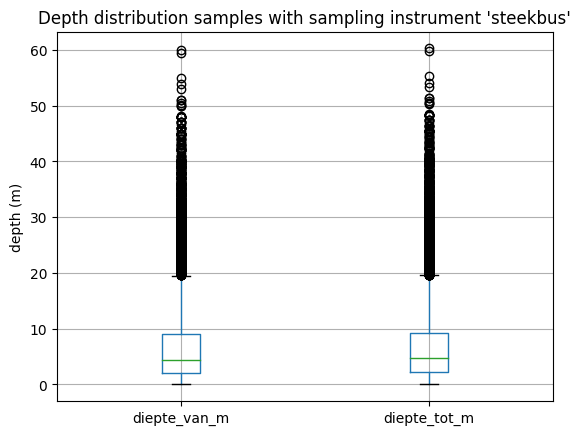

In [15]:
ax = df[df.diepte_tot_m != 0].boxplot()
ax.set_ylabel("depth (m)")
ax.set_title("Depth distribution samples with sampling instrument 'steekbus'")

## Finding the boreholes associated with the monsters and visualize results

In [19]:
# import the necessary modules (not included in the requirements of pydov!)
import geopandas as gpd

In [20]:
from pydov.search.boring import BoringSearch
from pydov.util.query import FuzzyJoin, Join
bs = BoringSearch()
bs.get_fields()['geom']

{'name': 'geom',
 'definition': None,
 'type': 'geometry',
 'list': False,
 'notnull': False,
 'query': False,
 'cost': 1}

In [13]:
boringen = bs.search(query=Join(df.iloc[0:100], on='pkey_boring', using='pkey_parents'), return_fields = ('pkey_boring','geom','boornummer'), max_features = 100)
boringen.head()

[000/001] .


,pkey_boring,geom,boornummer
0,https://oefen.dov.vlaanderen.be/data/boring/19...,POINT (151471 214936),GEO-70/569-A
1,https://oefen.dov.vlaanderen.be/data/boring/19...,POINT (151481 214814),GEO-70/569-B
2,https://oefen.dov.vlaanderen.be/data/boring/19...,POINT (157761 193731),GEO-72/045-b43
3,https://oefen.dov.vlaanderen.be/data/boring/19...,POINT (166358 229511),GEO-71/105-b31
4,https://oefen.dov.vlaanderen.be/data/boring/19...,POINT (166054 229460),GEO-71/105-b32


In [14]:
gdf = gpd.GeoDataFrame(boringen, geometry='geom', crs='EPSG:31370')
gdf.explore()

## Adding the sampled object to the monster dataframe

The default dataframe of the Monster datatype doesn't contains information about the 'sampled object' by default. This can be added to the dataframe as its subtype.

You can find which extra subtypes are available for a certain type with the `get_subtypes` method:

In [25]:
from pydov.types.monster import Monster

Monster.get_subtypes()

{'BemonsterdObject': {'name': 'BemonsterdObject',
  'class': pydov.types.monster.BemonsterdObject,
  'definition': 'Subtype listing the method used to make the borehole. It has the following fields: bemonsterd_object_type, bemonsterd_object_naam, bemonsterd_object_permkey.'}}

To get the details about the sampled objects, we can instantiate the search class with the `BemonsterdObject` subtype:

In [26]:
from pydov.types.monster import BemonsterdObject

monster_search = MonsterSearch(
    objecttype=Monster.with_subtype(BemonsterdObject)
)

When we now request information about the fields, this will include the extra fields from the subtype:

In [27]:
monster_search.get_fields()['bemonsterd_object_permkey']

{'name': 'bemonsterd_object_permkey',
 'type': 'string',
 'list': False,
 'definition': 'Een unieke DOV identifier in de vorm van een permkey.',
 'notnull': False,
 'query': False,
 'cost': 10}

And when we query the data, the extra fields will be part of the resulting dataframe:

In [28]:
df = monster_search.search(location=Within(Box(122000, 187000, 124000, 189000, epsg=31370)), max_features = 10)
df.head()

[000/001] .
[000/010] ..........


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,bemonsterd_object_type,bemonsterd_object_naam,bemonsterd_object_permkey
0,https://oefen.dov.vlaanderen.be/data/monster/2...,12,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,5.50,6.00,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
1,https://oefen.dov.vlaanderen.be/data/monster/2...,16A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.00,7.12,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
2,https://oefen.dov.vlaanderen.be/data/monster/2...,16B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.12,7.27,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
3,https://oefen.dov.vlaanderen.be/data/monster/2...,16C,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.27,7.43,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
4,https://oefen.dov.vlaanderen.be/data/monster/2...,16D,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.43,7.50,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282


Mind that one sample can originate from multiple 'sampled objects', so it's possible for one sample to be split into multiple rows. Also, since we are now requesting fields from XML, querying will be significantly slower than before.

## Get more details about a sample

To get more details about a sample than is available in the default dataframe, you can add an extra fieldset containing extra details.

You can find which extra fieldsets are available for a certain type with the `get_fieldsets` method:

In [3]:
from pydov.types.monster import Monster

Monster.get_fieldsets()

{'MonsterDetails': {'name': 'MonsterDetails',
  'class': pydov.types.monster.MonsterDetails,
  'definition': 'Fieldset containing fields with extra details about the sample. It has the following fields: tijdstip_monstername.'}}

In this case, the fieldset `MonsterDetails` is available, which will add the extra field `tijdstip_monstername`.

To use it, we can add the extra fields from the fieldset when instantiating our search instance:

In [4]:
from pydov.search.monster import MonsterSearch
from pydov.types.monster import Monster, MonsterDetails

monster_search = MonsterSearch(
    objecttype=Monster.with_extra_fields(MonsterDetails))

When we now request information about the fields, this will include the extra fields from the fieldset:

In [5]:
monster_search.get_fields()['tijdstip_monstername']

{'name': 'tijdstip_monstername',
 'type': 'string',
 'list': False,
 'definition': 'Tijdstip waarop het monster werd verkregen uit het bemonsterdObject.',
 'notnull': False,
 'query': False,
 'cost': 10}

And when we query the data, the extra details will be part of the resulting dataframe:

In [7]:
from owslib.fes2 import PropertyIsEqualTo

monster_search.search(
    query=PropertyIsEqualTo(
        'pkey_monster', 'https://oefen.dov.vlaanderen.be/data/monster/2022-324252')
)

[000/001] .
[000/001] c


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,tijdstip_monstername
0,https://oefen.dov.vlaanderen.be/data/monster/2...,CMON_Pae34829_laag_0_10_MG_2022,NaN,bodem,2022-01-19,0.0,0.1,geroerd,MENGMONSTER,csp,NaN,"VO - Instituut voor Landbouw-, Visserij- en Vo...",10:00:00
